# Introduction

In this example we will simulate bit-interleaved coded modulation (BICM) transmission. The transmitted signal is spread over several subcarriers in the frequency domain, termed orthogonal frequency division multiplexing (OFDM). The radio channel is frequency selective fading channel.

Refer to Section 2.1 of the paper "Deep Learning for Frame Error Probability Prediction in BICM-OFDM Systems" for a brief description of the complete radio link chain (https://arxiv.org/abs/1710.11270). The block diagram is reproduced below for reference:  

<img src="radio_link_chain.PNG">

In [2]:
import itpp
from matplotlib import pyplot as plt

# Setup simulation parameters

In [3]:
modulation_order = 1 # Bits per modulated symbol for each subcarrier
nrof_subcarriers = 256
nrof_transmit_bits = nrof_subcarriers * modulation_order

nrof_information_bits = 80 # Information bits per channel use

nrof_channel_use = 100000

print('Transmitted bits per channel use: %d'%(nrof_transmit_bits))

Transmitted bits per channel use: 256


# Set the Random number generator seed for reproduceability

In [4]:
itpp.RNG_reset(42)

# Setup the channel coder

In [5]:
conv_code = itpp.comm.Convolutional_Code()

generators = itpp.ivec(3)
generators[0] = 91  # Octal 0133
generators[1] = 101 # Octal 0145
generators[2] = 125 # Octal 0175
constraint_length = 7
conv_code.set_generator_polynomials(generators, constraint_length)

dummy = itpp.bvec()
conv_code.encode_tail(itpp.randb(nrof_information_bits), dummy)
nrof_coded_bits = dummy.length() # find out how long the coded blocks are

print('Nominal channel code rate: %f'%(float(nrof_information_bits) / float(nrof_coded_bits)))
print('Transmitted channel code rate: %f'%(float(nrof_information_bits) / float(nrof_transmit_bits)))

Nominal channel code rate: 0.310078
Transmitted channel code rate: 0.312500


# Setup the Modulator

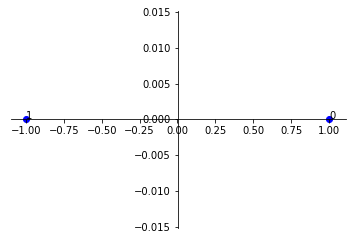

In [6]:
if modulation_order == 1:
    modulator = itpp.comm.BPSK_c()
elif modulation_order in [2, 4, 6, 8]:
    modulator = itpp.comm.QAM(int(itpp.math.pow(2, modulation_order)))
else:
    print('Modulation order %d not supported'%(modulation_order))

# Plot the constellation symbols
plt.figure()
indices = modulator.get_bits2symbols().to_numpy_ndarray()
constellation = modulator.get_symbols().to_numpy_ndarray()
for i, c in zip(indices, constellation):
    plt.scatter(c.real, c.imag, color='b')
    plt.annotate(i, [c.real, c.imag])

# Reposition the axes to center of plot
plt.gca().spines['left'].set_position('center')
plt.gca().spines['bottom'].set_position('center')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')

plt.show()

# Setup a frequency selective channel

Text(0.5,0,'Channel Magnitude')

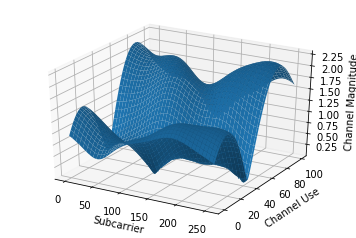

In [7]:
channel_model = itpp.comm.Channel_Specification(itpp.comm.CHANNEL_PROFILE.ITU_Vehicular_A)
channel = itpp.comm.TDL_Channel(channel_model, sampling_time = 1e-6)
channel.set_norm_doppler(0.01)

# Generate the channel samples
channel_impulse_response = itpp.cmat()
channel.generate(nrof_channel_use, channel_impulse_response)
channel_frequency_response = itpp.cmat()
channel.calc_frequency_response(channel_impulse_response, channel_frequency_response, fft_size= nrof_subcarriers)

# Plot the magnitude of first 100 channel samples
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

channel_magnitude = itpp.math.abs(channel_frequency_response)

plt.figure()
Z = channel_magnitude.get_cols(0, 99).to_numpy_ndarray()
x = np.arange(0, nrof_subcarriers)
y = np.arange(0, 100)
X, Y = np.meshgrid(x, y)
plt.gca(projection='3d').plot_surface(X, Y, np.transpose(Z))

plt.gca().set_xlabel('Subcarrier')
plt.gca().set_ylabel('Channel Use')
plt.gca().set_zlabel('Channel Magnitude')

# Generate transmission symbols

In [8]:
noise_variance = 0.02
soft_values = itpp.vec(nrof_coded_bits)
success = itpp.bvec(nrof_channel_use)
for i in range(nrof_channel_use):
    
    # --------------------------------------------------------------------
    # Transmitter
    # --------------------------------------------------------------------
    
    # Generate random information bits
    information_bits = itpp.randb(nrof_information_bits)
    
    # Channel code the information bits
    code_bits = conv_code.encode_tail(information_bits)
    
    # Extract code bits for transmission
    if code_bits.length() > nrof_transmit_bits:
        transmit_bits = code_bits.left(nrof_transmit_bits)
    else:
        transmit_bits = code_bits
    
    # Modulate the transmit bits to constellation symbols
    modulated_symbols = modulator.modulate_bits(transmit_bits)

    # Load the modulated symbols to OFDM subcarriers
    ofdm_symbols = itpp.signal.ifft(modulated_symbols, nrof_subcarriers)
    
    # --------------------------------------------------------------------
    # Channel
    # --------------------------------------------------------------------
    
    # Extract the frequency domain (complex) channel coefficients 
    channel_coefficents = channel_frequency_response.get_col(i)
    
    # Generate random white Gaussian noise for the complex symbols
    noise = itpp.randn_c(nrof_subcarriers) * (0.5 * itpp.math.sqrt(noise_variance))
    
    # Propagate the OFDM symbols through channel and add the noise
    received_symbols = itpp.elem_mult(ofdm_symbols, channel_coefficents) + noise
    
    # --------------------------------------------------------------------
    # Receiver
    # --------------------------------------------------------------------
    
    # De-multiplex the OFDM symbols
    demultiplexed_symbols = itpp.signal.fft(received_symbols, nrof_subcarriers)
    
    # Demodulate the symbols to soft values (log-likelihood ratios)
    demodulated_soft_values = modulator.demodulate_soft_bits(demultiplexed_symbols, channel_coefficents, noise_variance, itpp.comm.Soft_Method.LOGMAP)
    
    # Pad the soft values with zeros before channel decoding
    if nrof_coded_bits > nrof_transmit_bits:
        demodulated_soft_values.ins(nrof_transmit_bits, itpp.zeros(nrof_coded_bits - nrof_transmit_bits))
    
    # Decode the demodulated values to re-construct the information bits
    decoded_bits = conv_code.decode_tail(demodulated_soft_values)

    # Collect statistics on transmission success
    if information_bits == decoded_bits:
        success[i] = itpp.bin(True)
    else:
        success[i] = itpp.bin(False)
        
error_rate = 1.0 - np.mean(success.to_numpy_ndarray())
print('Error rate: %f'%(error_rate))

KeyboardInterrupt: 

# Save the data

In [93]:
channel_magnitude = itpp.math.abs(channel_frequency_response).to_numpy_ndarray()
transmission_success = success.to_numpy_ndarray()

np.save('datafile.npy', {'channel_magnitude': channel_magnitude,
                         'transmission_success': transmission_success})

# Load the data

In [94]:
data = np.load('datafile.npy')[()]
print(data['channel_magnitude'].shape)
print(data['transmission_success'].shape)

(256, 1000)
(1000,)
